# Import Libraries

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('max_columns', 150)

# Dataset Overview

In [5]:
sales_df = pd.read_csv('sales.csv', index_col=0)
stock_df = pd.read_csv('sensor_stock_levels.csv', index_col=0)
temp_df = pd.read_csv('sensor_storage_temperature.csv', index_col=0)

In [4]:
print(f'sales dataset consist of {sales_df.shape[0]} rows and {sales_df.shape[1]} columns')
print(f'stock dataset consist of {stock_df.shape[0]} rows and {stock_df.shape[1]} columns')
print(f'temp dataset consist of {temp_df.shape[0]} rows and {temp_df.shape[1]} columns')

sales dataset consist of 7829 rows and 9 columns
stock dataset consist of 15000 rows and 4 columns
temp dataset consist of 23890 rows and 3 columns


## Sales Dataset

In [15]:
# Create Data Info After Convert

list_item = []
for col in sales_df.columns:
    list_item.append([col, sales_df[col].dtype, sales_df[col].isna().sum(), 100*sales_df[col].isna().sum()/len(sales_df[col]), sales_df[col].nunique(), sales_df[col].unique()[:4]])
desc_df = pd.DataFrame(data=list_item, columns='feature data_type null_num null_pct unique_num unique_sample'.split())
desc_df

,feature,data_type,null_num,null_pct,unique_num,unique_sample
0,transaction_id,object,0,0.0,7829,"[a1c82654-c52c-45b3-8ce8-4c2a1efe63ed, 931ad55..."
1,timestamp,datetime64[ns],0,0.0,7738,"[2022-03-02T09:51:38.000000000, 2022-03-06T10:..."
2,product_id,object,0,0.0,300,"[3bc6c1ea-0198-46de-9ffd-514ae3338713, ad81b46..."
3,category,object,0,0.0,22,"[fruit, vegetables, refrigerated items, frozen]"
4,customer_type,object,0,0.0,5,"[gold, standard, premium, basic]"
5,unit_price,float64,0,0.0,64,"[3.99, 0.19, 4.49, 1.49]"
6,quantity,int64,0,0.0,4,"[2, 1, 4, 3]"
7,total,float64,0,0.0,256,"[7.98, 3.99, 0.38, 0.76]"
8,payment_type,object,0,0.0,4,"[e-wallet, debit card, cash, credit card]"


## Stock Dataset

In [16]:
# Create Data Info After Convert

list_item = []
for col in stock_df.columns:
    list_item.append([col, stock_df[col].dtype, stock_df[col].isna().sum(), 100*stock_df[col].isna().sum()/len(stock_df[col]), stock_df[col].nunique(), stock_df[col].unique()[:4]])
desc_df = pd.DataFrame(data=list_item, columns='feature data_type null_num null_pct unique_num unique_sample'.split())
desc_df

,feature,data_type,null_num,null_pct,unique_num,unique_sample
0,id,object,0,0.0,15000,"[4220e505-c247-478d-9831-6b9f87a4488a, f2612b2..."
1,timestamp,datetime64[ns],0,0.0,14611,"[2022-03-07T12:13:02.000000000, 2022-03-07T16:..."
2,product_id,object,0,0.0,300,"[f658605e-75f3-4fed-a655-c0903f344427, de06083..."
3,estimated_stock_pct,float64,0,0.0,100,"[0.75, 0.48, 0.58, 0.79]"


## Temperature Dataset

In [17]:
# Create Data Info After Convert

list_item = []
for col in temp_df.columns:
    list_item.append([col, temp_df[col].dtype, temp_df[col].isna().sum(), 100*temp_df[col].isna().sum()/len(temp_df[col]), temp_df[col].nunique(), temp_df[col].unique()[:4]])
desc_df = pd.DataFrame(data=list_item, columns='feature data_type null_num null_pct unique_num unique_sample'.split())
desc_df

,feature,data_type,null_num,null_pct,unique_num,unique_sample
0,id,object,0,0.0,23890,"[d1ca1ef8-0eac-42fc-af80-97106efc7b13, 4b8a66c..."
1,timestamp,datetime64[ns],0,0.0,23890,"[2022-03-07T15:55:20.000000000, 2022-03-01T09:..."
2,temperature,float64,0,0.0,3140,"[2.96, 1.88, 1.78, 2.18]"


## Feature Engineering

In [6]:
# make a function
def convert_to_datetime(data: pd.DataFrame = None, column: str = None):
    dummy = data.copy()
    dummy[column] = pd.to_datetime(dummy[column], format='%Y-%m-%d %H:%M:%S')
    return dummy

In [7]:
sales_df = convert_to_datetime(sales_df, 'timestamp')
stock_df = convert_to_datetime(stock_df, 'timestamp')
temp_df = convert_to_datetime(temp_df, 'timestamp')

In [8]:
# make a function
from datetime import datetime

def hour(data: pd.DataFrame = None, column: str = None):
    dummy = data.copy()
    new_ts = dummy[column].tolist()
    new_ts = [i.strftime('%Y-%m-%d %H:00:00') for i in new_ts]
    new_ts = [datetime.strptime(i, '%Y-%m-%d %H:00:00') for i in new_ts]
    dummy[column] = new_ts
    return dummy

In [9]:
sales_df = hour(sales_df, 'timestamp')
stock_df = hour(stock_df, 'timestamp')
temp_df = hour(temp_df, 'timestamp')

In [10]:
# make an agregate columns
sales_agg = sales_df.groupby(['timestamp', 'product_id']).agg({'quantity': 'sum'}).reset_index()
stock_agg = stock_df.groupby(['timestamp', 'product_id']).agg({'estimated_stock_pct': 'mean'}).reset_index()
temp_agg = temp_df.groupby(['timestamp']).agg({'temperature': 'mean'}).reset_index()

## Join Dataset

In [11]:
merged_df = stock_agg.merge(sales_agg, on=['timestamp', 'product_id'], how='left')
merged_df = merged_df.merge(temp_agg, on='timestamp', how='left')
merged_df.head()

,timestamp,product_id,estimated_stock_pct,quantity,temperature
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.02885
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.02885
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,NaN,-0.02885
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,NaN,-0.02885
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,NaN,-0.02885


In [12]:
# fillna
merged_df['quantity'] = merged_df['quantity'].fillna(0)

In [13]:
# combine some more features onto this table too, including category and unit_price.
product_categories = sales_df[['product_id', 'category']]
product_categories = product_categories.drop_duplicates()

product_price = sales_df[['product_id', 'unit_price']]
product_price = product_price.drop_duplicates()

In [14]:
# merge again
merged_df = merged_df.merge(product_categories, on="product_id", how="left")
merged_df = merged_df.merge(product_price, on="product_id", how="left")

## Feature Extraction

In [15]:
merged_df['timestamp_day_of_month'] = merged_df['timestamp'].dt.day
merged_df['timestamp_day_of_week'] = merged_df['timestamp'].dt.dayofweek
merged_df['timestamp_hour'] = merged_df['timestamp'].dt.hour
merged_df.drop(columns=['timestamp'], inplace=True)

## Feature Encoding

In [16]:
merged_df = pd.get_dummies(merged_df, columns=['category'])
merged_df.drop(columns=['product_id'], inplace=True)

In [17]:
# Create Data Info After Convert

list_item = []
for col in merged_df.columns:
    list_item.append([col, merged_df[col].dtype, merged_df[col].isna().sum(), 100*merged_df[col].isna().sum()/len(merged_df[col]), merged_df[col].nunique(), merged_df[col].unique()[:4]])
desc_df = pd.DataFrame(data=list_item, columns='feature data_type null_num null_pct unique_num unique_sample'.split())
desc_df

,feature,data_type,null_num,null_pct,unique_num,unique_sample
0,estimated_stock_pct,float64,0,0.0,538,"[0.89, 0.14, 0.67, 0.82]"
1,quantity,float64,0,0.0,16,"[3.0, 0.0, 1.0, 6.0]"
2,temperature,float64,0,0.0,77,"[-0.028849840255591022, 1.2843137254901962, -0..."
3,unit_price,float64,0,0.0,64,"[11.19, 1.49, 14.19, 20.19]"
4,timestamp_day_of_month,int64,0,0.0,7,"[1, 2, 3, 4]"
5,timestamp_day_of_week,int64,0,0.0,7,"[1, 2, 3, 4]"
6,timestamp_hour,int64,0,0.0,11,"[9, 10, 11, 12]"
7,category_baby products,uint8,0,0.0,2,"[0, 1]"
8,category_baked goods,uint8,0,0.0,2,"[0, 1]"
9,category_baking,uint8,0,0.0,2,"[0, 1]"


In [34]:
merged_df.shape

(10845, 29)

# Exploratory Data Analysis

In [30]:
eda = merged_df.copy()
num = merged_df.columns

## Univariate Analysis

### Descriptive Statistic

In [31]:
eda.describe().T

,count,mean,std,min,25%,50%,75%,max
estimated_stock_pct,10845.0,0.505130,0.264519,0.01000,0.300000,0.500000,0.715000,1.000000
quantity,10845.0,0.908529,1.787680,0.00000,0.000000,0.000000,1.000000,15.000000
temperature,10845.0,-0.213678,0.649671,-1.84727,-0.657082,-0.230631,0.160429,1.435938
unit_price,10845.0,8.938575,5.390235,0.19000,4.990000,8.190000,12.490000,23.990000
timestamp_day_of_month,10845.0,4.010973,1.998378,1.00000,2.000000,4.000000,6.000000,7.000000
timestamp_day_of_week,10845.0,2.988566,1.998261,0.00000,1.000000,3.000000,5.000000,6.000000
timestamp_hour,10845.0,13.997234,3.165366,9.00000,11.000000,14.000000,17.000000,19.000000
category_baby products,10845.0,0.044998,0.207309,0.00000,0.000000,0.000000,0.000000,1.000000
category_baked goods,10845.0,0.049977,0.217907,0.00000,0.000000,0.000000,0.000000,1.000000
category_baking,10845.0,0.047856,0.213472,0.00000,0.000000,0.000000,0.000000,1.000000


### Boxplot

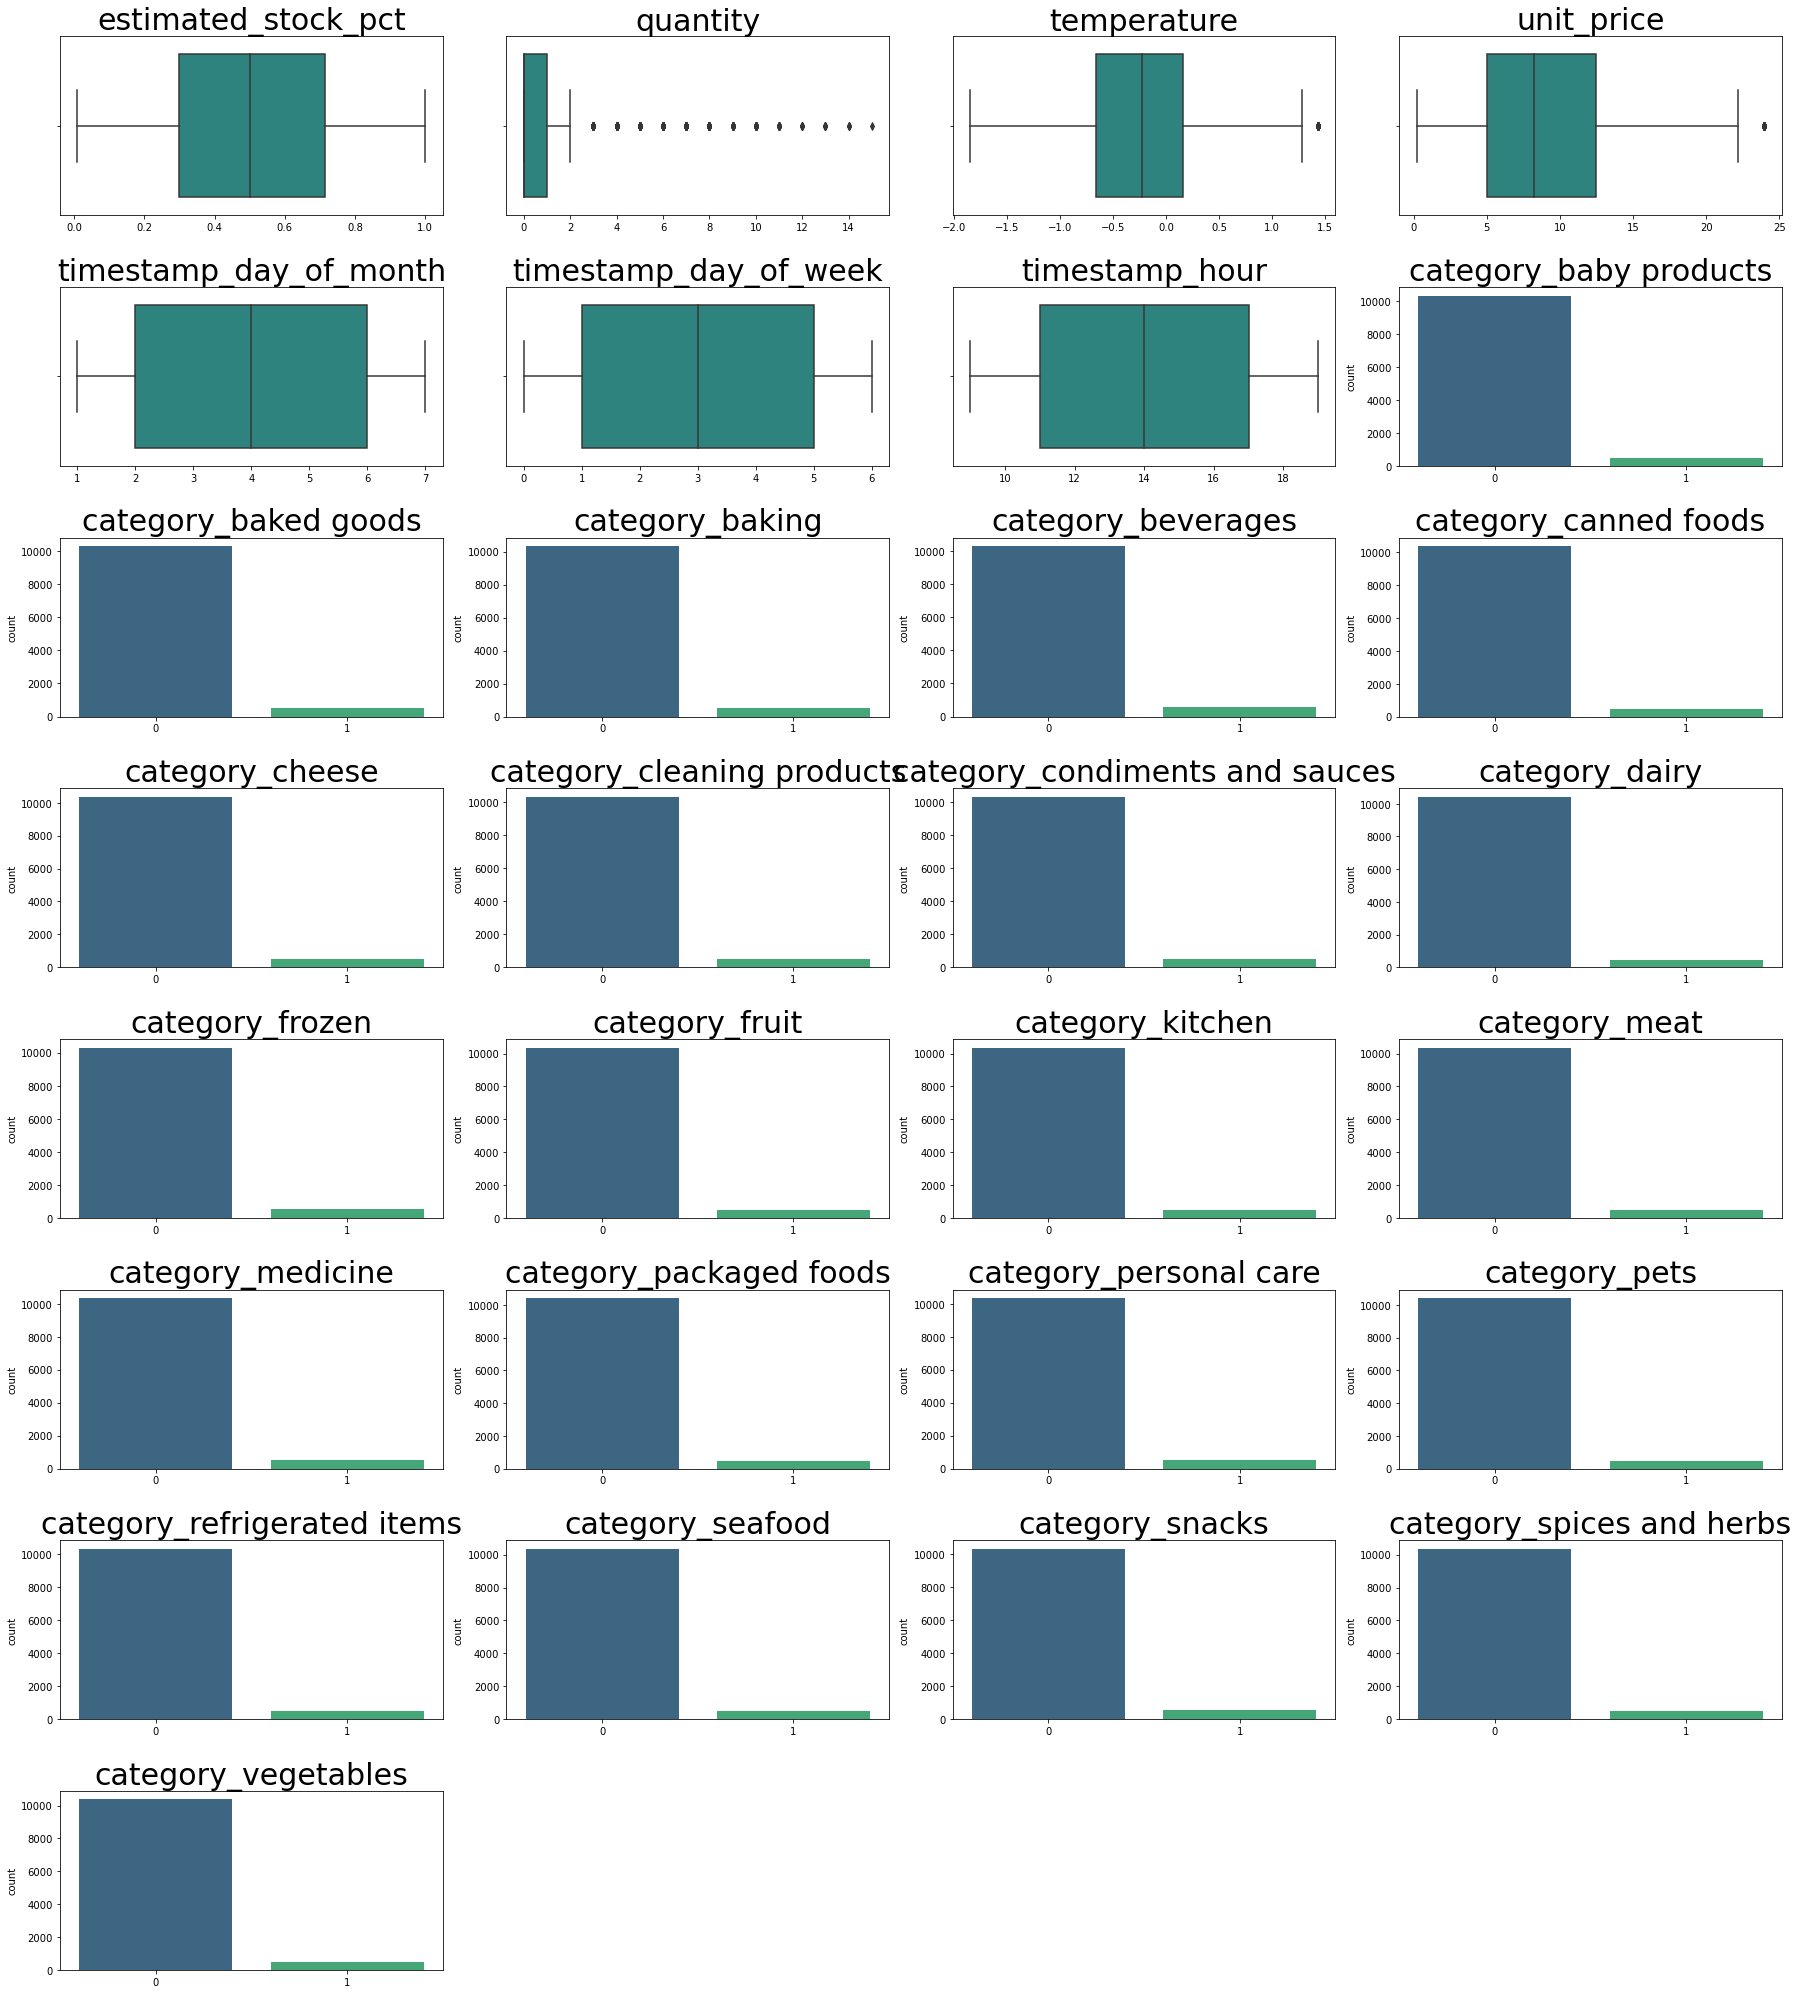

In [40]:
plt.figure(figsize=(25,28))
for i in range(0, len(num)):
    plt.subplot(8,4,i+1)
    if eda[num[i]].nunique() > 2:
        sns.boxplot(x=eda[num[i]], palette='viridis')
    else:
        sns.countplot(x=eda[num[i]], palette='viridis')
    plt.title(num[i], fontsize=30)
    plt.xlabel(' ')
    plt.tight_layout()

### Kernell Density Plot

In [43]:
num[:7]

Index(['estimated_stock_pct', 'quantity', 'temperature', 'unit_price',
       'timestamp_day_of_month', 'timestamp_day_of_week', 'timestamp_hour'],
      dtype='object')

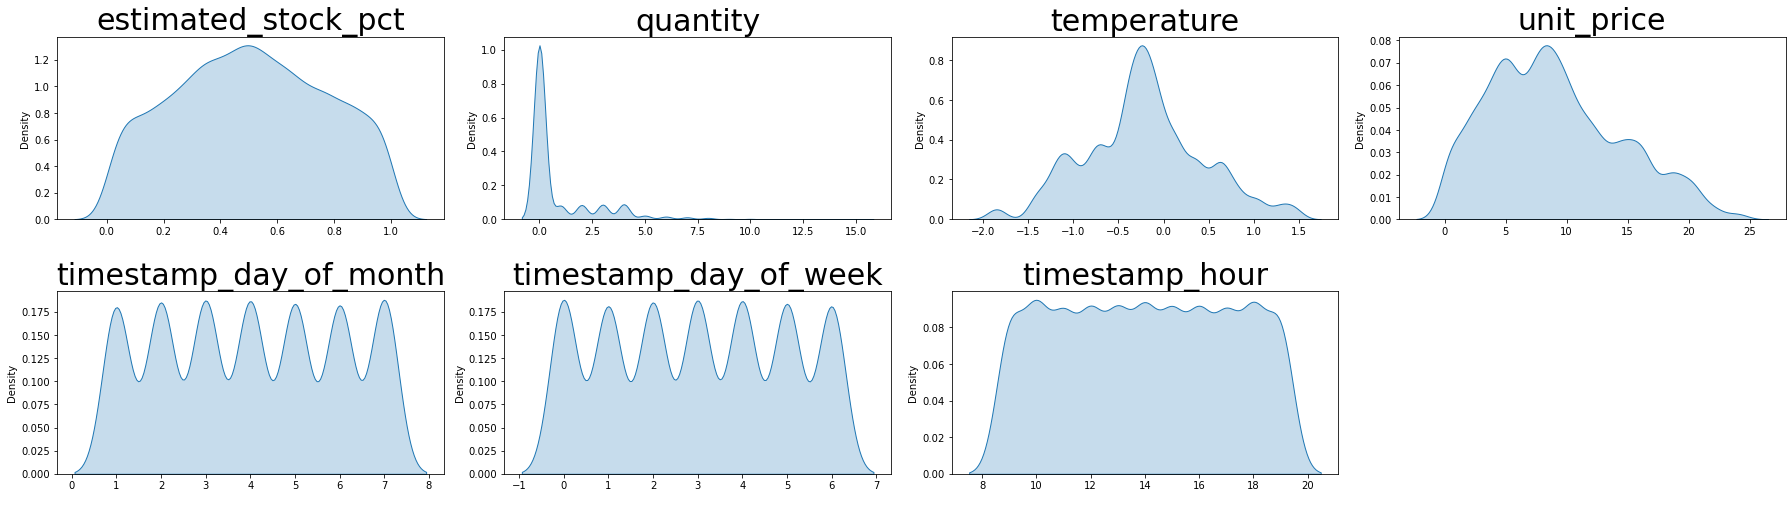

In [44]:
plt.figure(figsize=(25,28))
for i in range(0, len(num[:7])):
    plt.subplot(8,4,i+1)
    sns.kdeplot(x=eda[num[:7][i]], palette='viridis', shade=True)
    plt.title(num[:7][i], fontsize=30)
    plt.xlabel(' ')
    plt.tight_layout()

### Correlation Heatmap

<AxesSubplot:>

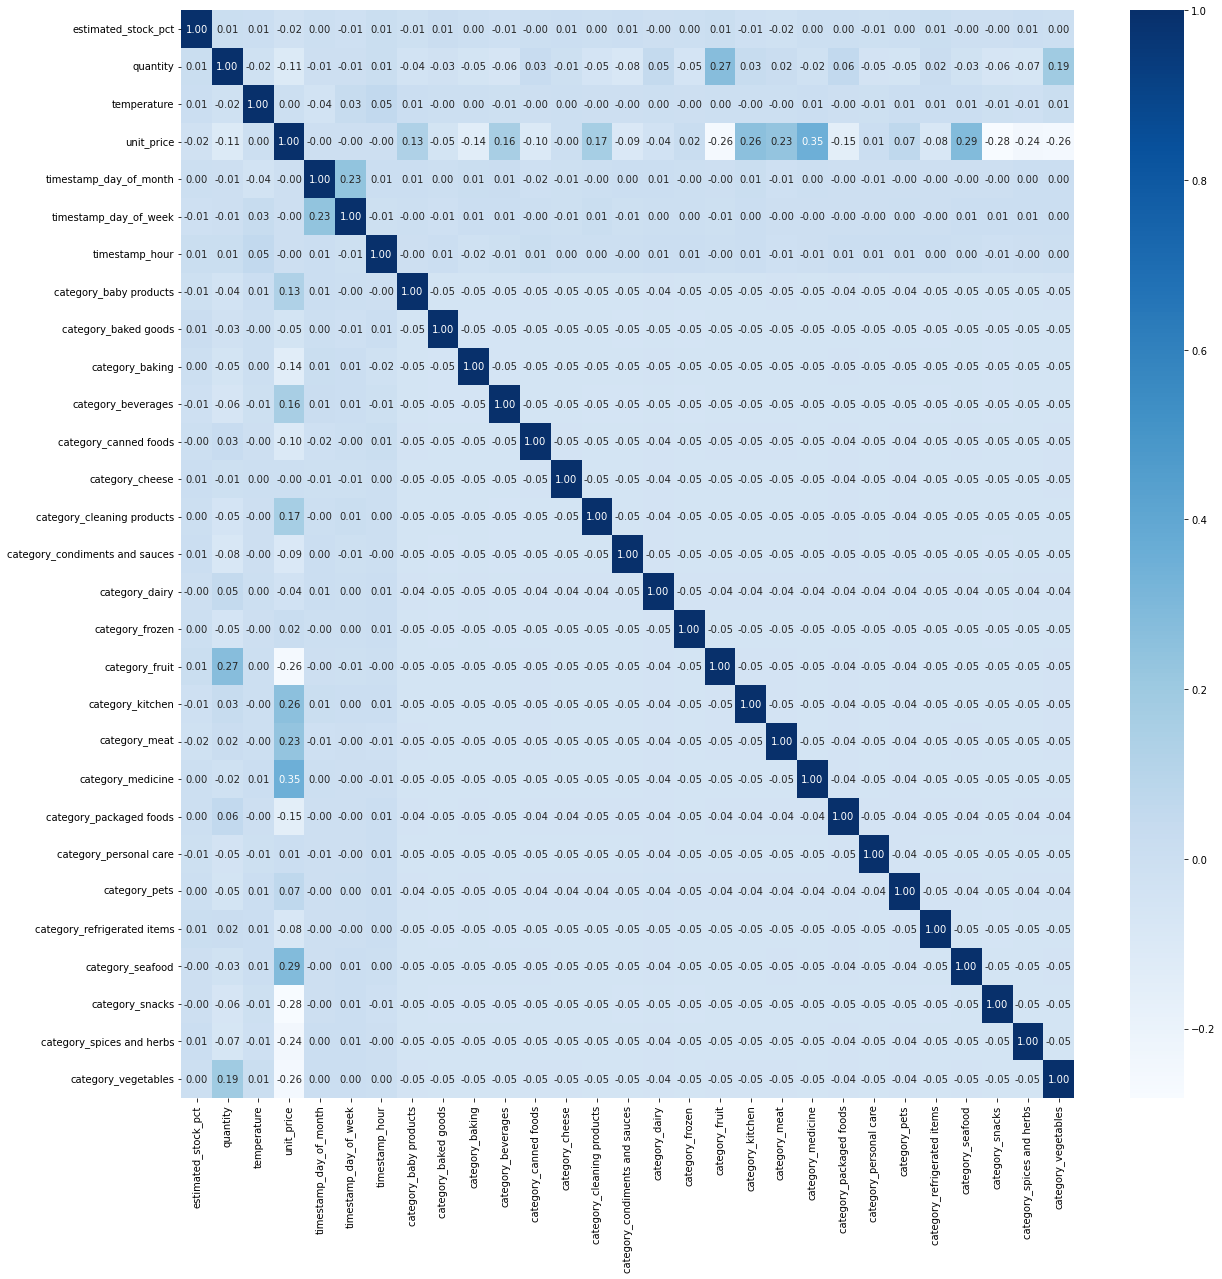

In [45]:
plt.figure(figsize=(20, 20))
sns.heatmap(eda[num].corr(), cmap='Blues', annot=True, fmt='.2f')

# Modeling

## Train Test Split

In [18]:
X = merged_df.drop(columns=['estimated_stock_pct'])
y = merged_df['estimated_stock_pct']

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [20]:
X_train.shape, X_test.shape

((8133, 28), (2712, 28))

## Feature Scaling

In [21]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Training and Evaluation

In [22]:
from sklearn.model_selection import cross_val_predict  # For K-Fold Cross Validation
from sklearn.metrics import r2_score  # For find accuracy with R2 Score
from sklearn.metrics import mean_squared_error  # For MSE
from math import sqrt  # For squareroot operation

### Simple Linear Regression

In [60]:
lr = LinearRegression().fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print(lr.score(X_test, y_test))

-0.0046561720388564876


In [61]:
from sklearn.linear_model import LinearRegression  # Import Linear Regression model

multiple_linear_reg = LinearRegression(fit_intercept=False)  # Create a instance for Linear Regression model
multiple_linear_reg.fit(X_train, y_train)  # Fit data to the model

LinearRegression(fit_intercept=False)

In [62]:
# Prediction with training dataset:
y_pred_MLR_train = multiple_linear_reg.predict(X_train)

# Prediction with testing dataset:
y_pred_MLR_test = multiple_linear_reg.predict(X_test)

# Find training accuracy for this model:
accuracy_MLR_train = r2_score(y_train, y_pred_MLR_train)
print("Training R2 Score for Multiple Linear Regression Model: ", accuracy_MLR_train)

# Find testing accuracy for this model:
accuracy_MLR_test = r2_score(y_test, y_pred_MLR_test)
print("Testing R2 Score for Multiple Linear Regression Model: ", accuracy_MLR_test)

# Find RMSE for training data:
RMSE_MLR_train = sqrt(mean_squared_error(y_train, y_pred_MLR_train))
print("RMSE for Training Data: ", RMSE_MLR_train)

# Find RMSE for testing data:
RMSE_MLR_test = sqrt(mean_squared_error(y_test, y_pred_MLR_test))
print("RMSE for Testing Data: ", RMSE_MLR_test)

# Prediction with 10-Fold Cross Validation:
y_pred_cv_MLR = cross_val_predict(multiple_linear_reg, X, y, cv=10)

# Find accuracy after 10-Fold Cross Validation
accuracy_cv_MLR = r2_score(y, y_pred_cv_MLR)
print("R2 Score for 10-Fold Cross Predicted Multiple Linaer Regression Model: ", accuracy_cv_MLR)

Training R2 Score for Multiple Linear Regression Model:  0.003244784103737519
Testing R2 Score for Multiple Linear Regression Model:  -0.004696267459798786
RMSE for Training Data:  0.2641683753321353
RMSE for Testing Data:  0.26484739782215927
R2 Score for 10-Fold Cross Predicted Multiple Linaer Regression Model:  -0.0046996530178917695


### Polynomial

In [55]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_features = PolynomialFeatures(degree=3)  # Create a PolynomialFeatures instance in degree 3
x_train_poly = polynomial_features.fit_transform(X_train)  # Fit and transform the training data to polynomial
x_test_poly = polynomial_features.fit_transform(X_test)  # Fit and transform the testing data to polynomial

polynomial_reg = LinearRegression(fit_intercept=False)  # Create a instance for Linear Regression model
polynomial_reg.fit(x_train_poly, y_train)  # Fit data to the model

LinearRegression(fit_intercept=False)

In [56]:
# Prediction with training dataset:
y_pred_PR_train = polynomial_reg.predict(x_train_poly)

# Prediction with testing dataset:
y_pred_PR_test = polynomial_reg.predict(x_test_poly)

# Find training accuracy for this model:
accuracy_PR_train = r2_score(y_train, y_pred_PR_train)
print("Training R2 Score for Polynomial Regression Model: ", accuracy_PR_train)

# Find testing accuracy for this model:
accuracy_PR_test = r2_score(y_test, y_pred_PR_test)
print("Testing R2 Score for Polynomial Regression Model: ", accuracy_PR_test)

# Find RMSE for training data:
RMSE_PR_train = sqrt(mean_squared_error(y_train, y_pred_PR_train))
print("RMSE for Training Data: ", RMSE_PR_train)

# Find RMSE for testing data:
RMSE_PR_test = sqrt(mean_squared_error(y_test, y_pred_PR_test))
print("RMSE for Testing Data: ", RMSE_PR_test)

# Prediction with 10-Fold Cross Validation:
y_pred_cv_PR = cross_val_predict(polynomial_reg, polynomial_features.fit_transform(X), y, cv=10)

# Find accuracy after 10-Fold Cross Validation
accuracy_cv_PR = r2_score(y, y_pred_cv_PR)
print("R2 Score for 10-Fold Cross Predicted Polynomial Regression Model: ", accuracy_cv_PR)

Training R2 Score for Polynomial Regression Model:  0.06873047981483138
Testing R2 Score for Polynomial Regression Model:  -0.08276086648528946
RMSE for Training Data:  0.2553431791565973
RMSE for Testing Data:  0.2749442181983139
R2 Score for 10-Fold Cross Predicted Polynomial Regression Model:  -0.6955513467971162


### Decision Tree Regressor

In [63]:
from sklearn.tree import DecisionTreeRegressor  # Import Decision Tree Regression model

decision_tree_reg = DecisionTreeRegressor(max_depth=5, random_state=13)  # Create a instance for Decision Tree Regression model
decision_tree_reg.fit(X_train, y_train)  # Fit data to the model

DecisionTreeRegressor(max_depth=5, random_state=13)

In [64]:
# Prediction with training dataset:
y_pred_DTR_train = decision_tree_reg.predict(X_train)

# Prediction with testing dataset:
y_pred_DTR_test = decision_tree_reg.predict(X_test)

# Find training accuracy for this model:
accuracy_DTR_train = r2_score(y_train, y_pred_DTR_train)
print("Training Accuracy for Decision Tree Regression Model: ", accuracy_DTR_train)

# Find testing accuracy for this model:
accuracy_DTR_test = r2_score(y_test, y_pred_DTR_test)
print("Testing Accuracy for Decision Tree Regression Model: ", accuracy_DTR_test)

# Find RMSE for training data:
RMSE_DTR_train = sqrt(mean_squared_error(y_train, y_pred_DTR_train))
print("RMSE for Training Data: ", RMSE_DTR_train)

# Find RMSE for testing data:
RMSE_DTR_test = sqrt(mean_squared_error(y_test, y_pred_DTR_test))
print("RMSE for Testing Data: ", RMSE_DTR_test)

# Prediction with 10-Fold Cross Validation:
y_pred_cv_DTR = cross_val_predict(decision_tree_reg, X, y, cv=10)

# Find accuracy after 10-Fold Cross Validation
accuracy_cv_DTR = r2_score(y, y_pred_cv_DTR)
print("Accuracy for 10-Fold Cross Predicted Decision Tree Regression Model: ", accuracy_cv_DTR)

Training Accuracy for Decision Tree Regression Model:  0.012984203669633043
Testing Accuracy for Decision Tree Regression Model:  -0.010015822529052976
RMSE for Training Data:  0.2628745960783444
RMSE for Testing Data:  0.26554761459469217
Accuracy for 10-Fold Cross Predicted Decision Tree Regression Model:  -0.019362005982408448


### Random Forest Regressor

In [65]:
from sklearn.ensemble import RandomForestRegressor  # Import Random Forest Regression model

random_forest_reg = RandomForestRegressor(n_estimators=400, max_depth=5, random_state=13)  # Create a instance for Random Forest Regression model
random_forest_reg.fit(X_train, y_train)  # Fit data to the model

RandomForestRegressor(max_depth=5, n_estimators=400, random_state=13)

In [ ]:
# Prediction with training dataset:
y_pred_RFR_train = random_forest_reg.predict(X_train)

# Prediction with testing dataset:
y_pred_RFR_test = random_forest_reg.predict(X_test)

# Find training accuracy for this model:
accuracy_RFR_train = r2_score(y_train, y_pred_RFR_train)
print("Training Accuracy for Random Forest Regression Model: ", accuracy_RFR_train)

# Find testing accuracy for this model:
accuracy_RFR_test = r2_score(y_test, y_pred_RFR_test)
print("Testing Accuracy for Random Forest Regression Model: ", accuracy_RFR_test)

# Find RMSE for training data:
RMSE_RFR_train = sqrt(mean_squared_error(y_train, y_pred_RFR_train))
print("RMSE for Training Data: ", RMSE_RFR_train)

# Find RMSE for testing data:
RMSE_RFR_test = sqrt(mean_squared_error(y_test, y_pred_RFR_test))
print("RMSE for Testing Data: ", RMSE_RFR_test)

# Prediction with 10-Fold Cross Validation:
y_pred_cv_RFR = cross_val_predict(random_forest_reg, X, y, cv=10)

# Find accuracy after 10-Fold Cross Validation
accuracy_cv_RFR = r2_score(y, y_pred_cv_RFR)
print("Accuracy for 10-Fold Cross Predicted Random Forest Regression Model: ", accuracy_cv_RFR)

Training Accuracy for Random Forest Regression Model:  0.02820336589148076
Testing Accuracy for Random Forest Regression Model:  -0.0019267336084993758
RMSE for Training Data:  0.2608400423335781
RMSE for Testing Data:  0.2644821083076123


### SVR

In [38]:
from sklearn.svm import SVR  # Import SVR model

support_vector_reg = SVR(gamma="auto", kernel="linear", C=1000)  # Create a instance for Support Vector Regression model
support_vector_reg.fit(X_train, y_train)  # Fit data to the model

SVR(C=1000, gamma='auto', kernel='linear')

In [ ]:
# Prediction with training dataset:
y_pred_SVR_train = support_vector_reg.predict(X_train)

# Prediction with testing dataset:
y_pred_SVR_test = support_vector_reg.predict(X_test)

# Find training accuracy for this model:
accuracy_SVR_train = r2_score(y_train, y_pred_SVR_train)
print("Training Accuracy for Support Vector Regression Model: ", accuracy_SVR_train)

# Find testing accuracy for this model:
accuracy_SVR_test = r2_score(y_test, y_pred_SVR_test)
print("Testing Accuracy for Support Vector Regression Model: ", accuracy_SVR_test)

# Find RMSE for training data:
RMSE_SVR_train = sqrt(mean_squared_error(y_train, y_pred_SVR_train))
print("RMSE for Training Data: ", RMSE_SVR_train)

# Find RMSE for testing data:
RMSE_SVR_test = sqrt(mean_squared_error(y_test, y_pred_SVR_test))
print("RMSE for Testing Data: ", RMSE_SVR_test)

# Prediction with 10-Fold Cross Validation:
y_pred_cv_SVR = cross_val_predict(support_vector_reg, X, y, cv=10)

# Find accuracy after 10-Fold Cross Validation
accuracy_cv_SVR = r2_score(y, y_pred_cv_SVR)
print("Accuracy for 10-Fold Cross Predicted Support Vector Regression Model: ", accuracy_cv_SVR)

Training Accuracy for Support Vector Regression Model:  0.0019278117135723694
Testing Accuracy for Support Vector Regression Model:  -0.010459985340757427
RMSE for Training Data:  0.2643428352243994
RMSE for Testing Data:  0.2656059965568288


## Hyperparameter

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def eval_regression(model, pred, X_train, y_train, X_test, y_test):
    print("MAE: %.2f" % mean_absolute_error(y_test, pred)) # The MAE
    print("RMSE: %.2f" % mean_squared_error(y_test, pred, squared=False)) # The RMSE
    print('R2 score: %.2f' % r2_score(y_test, pred)) # Explained variance score: 1 is perfect prediction

### Ridge

In [23]:
# RIDGE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform

alpha = [0.01, 0.1, 1, 2, 5, 10, 100, 200, 230, 250, 265, 270, 275, 290, 300, 500] # alpha
solver = ['lsqr', 'auto', 'sag', 'saga']
hyperparameters = dict(alpha=alpha, solver=solver)

from sklearn.linear_model import Ridge
ridge_model = Ridge()
clf = RandomizedSearchCV(ridge_model, hyperparameters, cv=5, random_state=42, scoring='r2')

#Fitting Model
best_model = clf.fit(X_train, y_train)
pred = best_model.predict(X_test)
eval_regression(best_model, pred, X_train, y_train, X_test, y_test)

MAE: 0.22
RMSE: 0.26
R2 score: -0.00


### Random Forest

In [32]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 20)] 
criterion = ['squared_error', 'absolute_error', 'poisson']
max_depth = [int(x) for x in np.linspace(start=1, stop=30, num=20)]
min_samples_split = [int(x) for x in np.linspace(start=2, stop=20, num=12)]
min_samples_leaf = [int(x) for x in np.linspace(start=2, stop=20, num=13)]

hyperparameters = dict(n_estimators=n_estimators, 
                       criterion=criterion,
                       max_depth=max_depth,
                       min_samples_split=min_samples_split,
                       min_samples_leaf=min_samples_leaf)



rf_model = RandomForestRegressor()
rf = RandomizedSearchCV(rf_model, hyperparameters, cv=5, scoring='r2')

#Fitting Model
best_model = rf.fit(X_train, y_train)
best_params = best_model.best_params_
rf_model = RandomForestRegressor(**best_params)
rf_model.fit(X_train, y_train)
pred = rf_model.predict(X_test)
eval_regression(rf_model, pred, X_train, y_train, X_test, y_test)

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_asy

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_asy

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_asy

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_asy

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_asy

MAE: 0.22
RMSE: 0.26
R2 score: -0.00


## Feature Importance

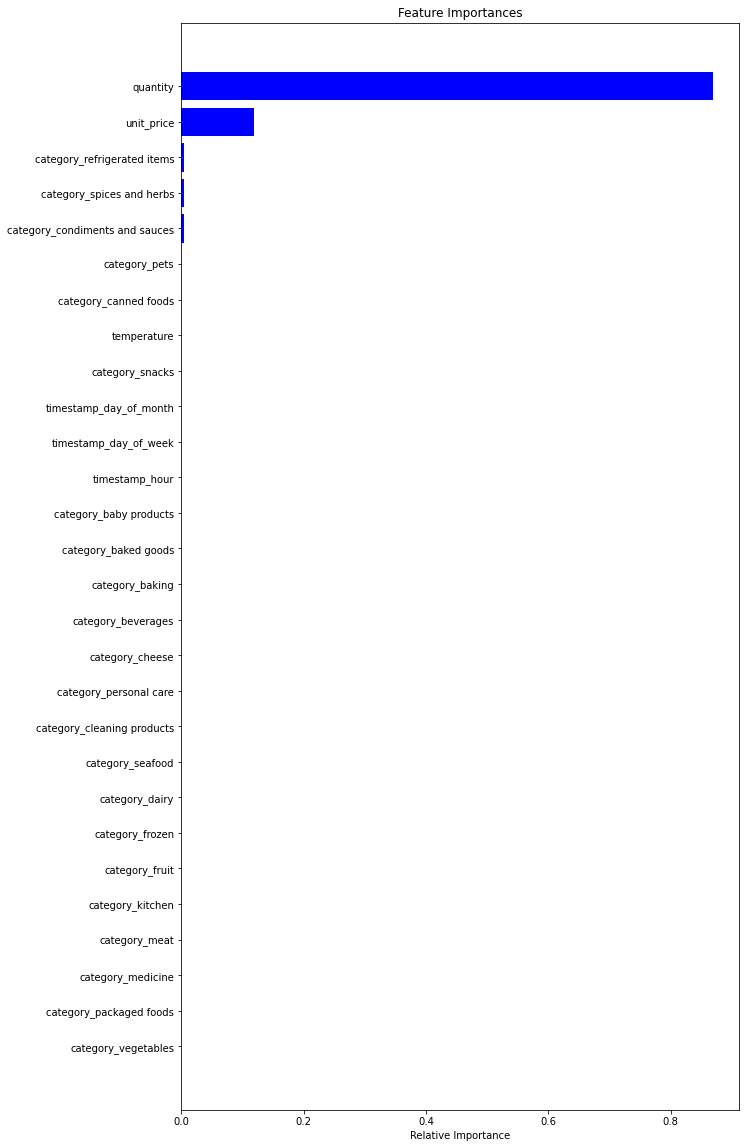

In [34]:
features = [i.split("__")[0] for i in X.columns]
importances = rf_model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10, 20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

This feature importance visualisation tells us:

* The product categories were not that important
* The unit price and quantity were important in predicting stock